# Projet (Thomas Levy)

In [1]:
spark

In [2]:
sc.applicationId

'local-1525334989752'

# Introduction
J'ai choisi de travailler sur un dataset issu d'une entreprise dans le monde de l'advertising contenant des données sur l'affichage de publicités video sur le terminal client de divers utilisateurs.

Chaque exemple a les éléments suivant:
* creative_id: A unique identifier of the video that has been displayed to the user
* user_operating_system: The user Operating System (OS)
* user_device: The user device type
* average_seconds_played: The average number of seconds the user usually watches our videos (only if we already know the user, based on the user history)
* cost: The cost we had to pay to display the video
* revenue: The revenue generated by this video when it has been watched


Au dela d'une analyse descriptive classique, mes objectifs seront de determiner:
1. Profit: Le profit est définie comme revenue - cost: Quel est le profit global de ce dataset? 
* Marge globale: La marge (i.e margin) est définie comme (revenue - cost) / revenue. Quelle est la marge globale du dataset?
* Profitabilité: Y-a-t-il des user Operating System plus profitable sur ce dataset?
* Prédiction: Sur une base de ce dataset, peut-on prédire si un affichage va générer un revenue (i.e revenue>0)

## Analyse classique
On observe le dataset et on remplace les valeurs inconnues.

In [3]:
sdf = spark.read.csv('dataSample/aft100k.csv', header=True, sep=",", inferSchema=True)

In [4]:
sdf.printSchema() #Display schema

root
 |-- creative_id: integer (nullable = true)
 |-- user_operating_system: string (nullable = true)
 |-- user_device: string (nullable = true)
 |-- average_seconds_played: double (nullable = true)
 |-- cost: double (nullable = true)
 |-- revenue: double (nullable = true)



In [5]:
sdf.count() #Nb d'elements

100000

In [10]:
sdf.show()

+-----------+---------------------+----------------+----------------------+--------------------+--------------------+
|creative_id|user_operating_system|     user_device|average_seconds_played|                cost|             revenue|
+-----------+---------------------+----------------+----------------------+--------------------+--------------------+
|     113521|              Android|           Phone|                  null|0.010127929187048683|                 0.0|
|     115340|              Windows|PersonalComputer|                   0.0|0.005936633479110449|                 0.0|
|     113582|              Android|           Phone|     7.142857074737549|0.004397506280822555|                 0.0|
|      97385|              Windows|PersonalComputer|                  null|0.006156508793151577|                 0.0|
|     114821|              Windows|PersonalComputer|                  null|0.001993672221050...|                 0.0|
|     113065|              Android|          Tablet|    

In [11]:
#Check columns with NA values
from pyspark.sql import functions as F
for colo in sdf.columns:
    if sdf.where(F.col(colo).isNull()).count()>0:
        print(colo,"column has NA value(s).")

user_device column has NA value(s).
average_seconds_played column has NA value(s).


In [12]:
sdf= sdf.na.fill({'average_seconds_played':0, 'user_device': 'unknown'}) #Fill the NAs

In [13]:
sdf.select('user_operating_system').distinct().show() #Valeurs possibles de user_operating_system

+---------------------+
|user_operating_system|
+---------------------+
|               RIM OS|
|              Fire OS|
|                  iOS|
|              unknown|
|                 OS X|
|                Linux|
|                macOS|
|            Chrome OS|
|        BlackBerry OS|
|              Android|
|                  BSD|
|              Windows|
+---------------------+



In [14]:
sdf.select('user_device').distinct().show() #Valeurs possibles de user_device

+----------------+
|     user_device|
+----------------+
|         unknown|
|     ConnectedTv|
|PersonalComputer|
|           Phone|
|          Tablet|
+----------------+



## Profit
Quelle est le profit global de ce dataset?

In [15]:
#Define profit as user defined function
from pyspark.sql import functions as F
from pyspark.sql.types import *
#from pyspark.sql import *
#import pyspark.StorageLevel as SL
def profit(x,y):
    return x-y

udf_profit = F.udf(profit, FloatType())

sdf = sdf.withColumn('profit',udf_profit(sdf.revenue,sdf.cost))
sdf.persist() #On persiste avec la col profit car il va etre utile plusieurs fois par la suite

DataFrame[creative_id: int, user_operating_system: string, user_device: string, average_seconds_played: double, cost: double, revenue: double, profit: float]

Détermination du profit et du revenue global:

In [16]:
#Profit et revenue total
sdf.agg({"profit": "sum", "revenue": "sum"}).show()

+-----------------+------------------+
|     sum(revenue)|       sum(profit)|
+-----------------+------------------+
|778.8723551116509|211.78095616403152|
+-----------------+------------------+



## Marge globale 
La marge (i.e margin) est définie comme (revenue - cost) / revenue.
Je vais determiner la marge globale de ce dataset:

In [17]:
ldf=sdf.agg({"profit": "sum", "revenue": "sum"}).toPandas() #Aggregate & Convert to (local) Panda Data Frame

In [18]:
print(ldf['sum(profit)'].iloc[0]/ldf['sum(revenue)'].iloc[0]) #Global margin

0.271907142132


## Profitabilité par OS
Je regarde quels sont les OS (i.e Operating Systems) les plus profitables (pour la marge et le profit):

In [19]:
## Profit et revenue par OS
snb=sdf.select(sdf.user_operating_system,sdf.profit,sdf.revenue,sdf.creative_id).groupby('user_operating_system')
snb=snb.agg({ 'profit':'sum', 'revenue':'sum', 'creative_id': 'count'})
snb.show()

+---------------------+-------------------+--------------------+------------------+
|user_operating_system|       sum(revenue)|         sum(profit)|count(creative_id)|
+---------------------+-------------------+--------------------+------------------+
|               RIM OS|                0.0|-0.00522909406572...|                 1|
|              Fire OS| 1.3980201160367163|  0.1425748411566019|               237|
|                  iOS| 309.09500082531406|  115.52177463275439|             37118|
|              unknown| 0.2020355235997801| 0.09399451222270727|                16|
|                 OS X|   34.8081235055762|   1.707774862908991|              4552|
|                Linux|  2.737310871371627|  0.3729219896486029|               376|
|                macOS| 16.599701182285987| 0.24802117884973995|              2274|
|            Chrome OS| 2.1154924268013753| 0.42812985531054437|               240|
|        BlackBerry OS|0.35703859270470206| 0.07739053695695475|            

In [20]:
#Marge par OS
def margin(x,y):
    if y==0.:
        return 0.
    else:
        return x/y

udf_margin = F.udf(margin, FloatType())

snb = snb.withColumn('margin',udf_margin('sum(profit)','sum(revenue)'))
snb = snb.sort('margin', ascending=False)
snb.show()

+---------------------+-------------------+--------------------+------------------+-----------+
|user_operating_system|       sum(revenue)|         sum(profit)|count(creative_id)|     margin|
+---------------------+-------------------+--------------------+------------------+-----------+
|                  BSD|0.06241741881455289|0.040429886896163225|                 5| 0.64773405|
|              unknown| 0.2020355235997801| 0.09399451222270727|                16| 0.46523756|
|                  iOS| 309.09500082531406|  115.52177463275439|             37118| 0.37374198|
|              Android| 117.57257184422097|   27.27936350827804|             19297|  0.2320215|
|              Windows|  293.9246428048952|   65.87380945311452|             35826| 0.22411802|
|        BlackBerry OS|0.35703859270470206| 0.07739053695695475|                58| 0.21675679|
|            Chrome OS| 2.1154924268013753| 0.42812985531054437|               240| 0.20237835|
|                Linux|  2.7373108713716

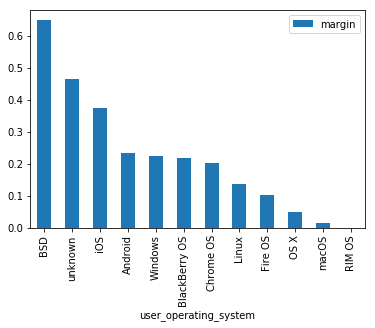

In [21]:
#Affichage du graphique de marge
%matplotlib inline
lnb=snb.toPandas() #Convert to Panda Data Frame
lnb.plot(y='margin', kind="bar", x='user_operating_system')

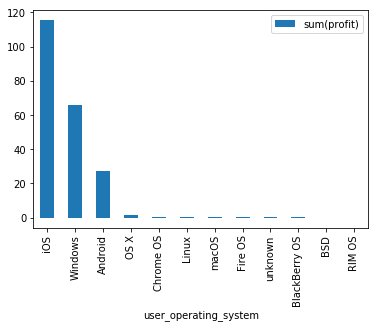

In [22]:
#Affichage du profit
snb = snb.sort('sum(profit)', ascending=False)
lnb=snb.toPandas() #Convert to Panda Data Frame
lnb.plot(y='sum(profit)', kind="bar", x='user_operating_system')

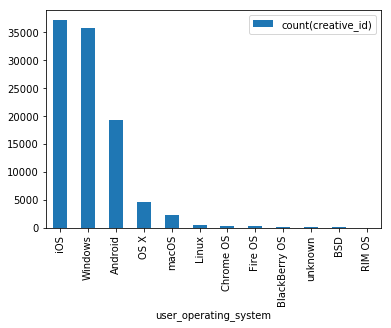

In [23]:
#Repartition des affichages pas OS
%matplotlib inline
snb = snb.sort('count(creative_id)', ascending=False)
lnb=snb.toPandas() #Convert to Panda Data Frame
lnb.plot(y='count(creative_id)', kind="bar", x='user_operating_system')

On constate que BSD a la meilleure marge mais iOS obtient le meilleur profit.
Toutefois, le résultat pour BSD est à relativiser vu le faible nombre d'affichage sur BSD.

# Prédiction
Sur une base de ce dataset, peut-on prédire si un affichage va générer un revenue (i.e revenue>0)?

On commence par construire une colonne 'event_revenue'=1 si le revenue est positif correspondant à la classe à prévoir.

In [24]:
sdf=sdf.withColumn('event_revenue', F.when(sdf.revenue > 0, 1).otherwise(0))

In [25]:
sdf.groupBy('event_revenue').count().show()

+-------------+-----+
|event_revenue|count|
+-------------+-----+
|            1|27044|
|            0|72956|
+-------------+-----+



On est donc dans un problème de classification binaire.

On va essayer de prédire le fait qu'il y a un revenue à partir de:
* user_device: champ catégoriel => transformé en vecteur (dummy)
* operating_system: champ catégoriel => transformé en vecteur (dummy)
* average_seconds_played: champ numérique
    
On commence en utilisant une regression logistique.

### Processing des features

In [26]:
#Transformation de user_device
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

udIndexer = StringIndexer(inputCol="user_device", outputCol="user_device_idx")
td = udIndexer.fit(sdf).transform(sdf)

udEncoder = OneHotEncoder(inputCol="user_device_idx", outputCol="feature_ud")
td=udEncoder.transform(td)
#td.select('feature_ud').show()

In [27]:
#Transformation de user_operating_system
osIndexer = StringIndexer(inputCol="user_operating_system", outputCol="operating_system_idx")
td = osIndexer.fit(td).transform(td)

osEncoder = OneHotEncoder(inputCol="operating_system_idx", outputCol="feature_os")
td=osEncoder.transform(td)
#td.select('feature_os').show()

In [28]:
#Aggregation des features
from pyspark.ml.feature import VectorAssembler
td=td.drop('features') #Drop col before creating it
vecAssembler = VectorAssembler(inputCols=["feature_os","feature_ud","average_seconds_played"], outputCol="features")
td=vecAssembler.transform(td)
#td.select('features').show()

In [29]:
#On split le dataset en train et test
[train, test] = td.randomSplit([0.75, 0.25], seed=1)

In [31]:
#On persiste ces données qui vont etre utilisé pour la partie ML
train.persist()
sdf.unpersist() #No need to persist sdf anymore
train.count()

75139

In [32]:
test.persist()
test.count()

24861

### Regression Logistic

In [33]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="event_revenue")
lrmodel = lr.fit(train)
lrmodel.coefficients

DenseVector([0.741, 0.5378, 0.6233, 0.5109, 0.4363, 0.4136, 0.1409, 0.1051, 0.1414, 0.9515, 0.1324, -1.1311, -1.2336, -0.8708, -0.663, 0.0168])

In [35]:
result = lrmodel.transform(test)
#result.show()
result.printSchema() #Display schema

root
 |-- creative_id: integer (nullable = true)
 |-- user_operating_system: string (nullable = true)
 |-- user_device: string (nullable = false)
 |-- average_seconds_played: double (nullable = false)
 |-- cost: double (nullable = true)
 |-- revenue: double (nullable = true)
 |-- profit: float (nullable = true)
 |-- event_revenue: integer (nullable = false)
 |-- user_device_idx: double (nullable = true)
 |-- feature_ud: vector (nullable = true)
 |-- operating_system_idx: double (nullable = true)
 |-- feature_os: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [40]:
result.select('event_revenue','rawPrediction','probability','prediction').show()

+-------------+--------------------+--------------------+----------+
|event_revenue|       rawPrediction|         probability|prediction|
+-------------+--------------------+--------------------+----------+
|            0|[1.16124261339717...|[0.76155843084681...|       0.0|
|            1|[1.16124261339717...|[0.76155843084681...|       0.0|
|            1|[0.99448491003755...|[0.72997286534838...|       0.0|
|            0|[1.18816771152288...|[0.76641320074128...|       0.0|
|            1|[1.26274722982230...|[0.77949866555905...|       0.0|
|            0|[1.17834338103050...|[0.76464980853713...|       0.0|
|            0|[1.17834338103050...|[0.76464980853713...|       0.0|
|            1|[0.74241711138028...|[0.67752418566032...|       0.0|
|            0|[1.17834338103050...|[0.76464980853713...|       0.0|
|            0|[1.17834338103050...|[0.76464980853713...|       0.0|
|            0|[1.17834338103050...|[0.76464980853713...|       0.0|
|            0|[1.17834338103050..

In [39]:
result.select('probability').collect()[:2]

[Row(probability=DenseVector([0.7616, 0.2384])),
 Row(probability=DenseVector([0.7616, 0.2384]))]

In [48]:
#On evalue ce model avec l'AreaUnderROC(AUROC)
from pyspark.ml.evaluation import BinaryClassificationEvaluator 
evaluator = BinaryClassificationEvaluator(labelCol='event_revenue')
evaluator.evaluate(result)
#evaluator.getMetricName()

0.5601811579955163

Pour avoir d'autres éléments d'évaluation, nous allons afficher la matrice de confusion:

In [49]:
#On va creer la matrice confusion
def evaluatePos(ytrue,ypred):
    if (ytrue==1) and (ypred==1.0):
        return "TP"
    elif ytrue==1:
        return "FN"
    elif (ytrue==0) and (ypred==0.0):
        return "TN"
    else:
        return "FP"

udf_evaluatePos = F.udf(evaluatePos, StringType())

result = result.withColumn('confusion',udf_evaluatePos('event_revenue','prediction'))
result.select('event_revenue','prediction','confusion').show()

+-------------+----------+---------+
|event_revenue|prediction|confusion|
+-------------+----------+---------+
|            0|       0.0|       TN|
|            1|       0.0|       FN|
|            1|       0.0|       FN|
|            0|       0.0|       TN|
|            1|       0.0|       FN|
|            0|       0.0|       TN|
|            0|       0.0|       TN|
|            1|       0.0|       FN|
|            0|       0.0|       TN|
|            0|       0.0|       TN|
|            0|       0.0|       TN|
|            0|       0.0|       TN|
|            0|       0.0|       TN|
|            1|       0.0|       FN|
|            0|       0.0|       TN|
|            0|       0.0|       TN|
|            0|       0.0|       TN|
|            0|       0.0|       TN|
|            1|       0.0|       FN|
|            1|       0.0|       FN|
+-------------+----------+---------+
only showing top 20 rows



In [50]:
#On converti en DataFrame local
lconfusion=result.groupBy('confusion').count().toPandas()
print(lconfusion)

  confusion  count
0        TP      3
1        TN  18072
2        FN   6771
3        FP     15


In [51]:
def myConfusionMatrix(ldf):
    #We first convert the DataFrame to a Dictionary for allowing display
    confusionMap= {'TN':0,'FP':0,'FN':0,'TP':0} #Initialize dictionary
    nelts=ldf.shape[0]
    for i in range(nelts):
        confusionMap[ldf['confusion'].iloc[i]]=ldf['count'].iloc[i]
        
    print("Confusion matrix:")
    print("TN="+str(confusionMap['TN'])+"  \t\tFP="+str(confusionMap['FP']))
    print("FN="+str(confusionMap['FN'])+"  \t\tTP="+str(confusionMap['TP']))

myConfusionMatrix(lconfusion)

Confusion matrix:
TN=18072  		FP=15
FN=6771  		TP=3


In [52]:
#On fait de la cross-validation pour optimiser les hyper-parametres
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

In [53]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Run cross validations
cvModel = cv.fit(train)

# Use test set to measure the accuracy of our model on new data
predictions = cvModel.transform(test)
# Evaluate best model
evaluator.evaluate(predictions)

0.5593847987523611

In [54]:
result=predictions
result=result.withColumn('confusion',udf_evaluatePos('event_revenue','prediction'))
lconfusion=result.groupBy('confusion').count().toPandas()
myConfusionMatrix(lconfusion)

Confusion matrix:
TN=18087  		FP=0
FN=6774  		TP=0


En regression logistique, La meilleure prédiction prédit toujours event_revenue=0 ce qui n'est pas terrible.
On va voir si on peut faire mieux avec Random Forest

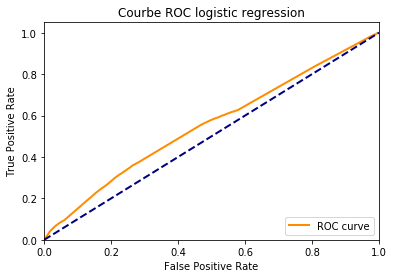

In [55]:
#On affiche la courbe de ROC
mySum = cvModel.bestModel.summary
lroc=mySum.roc.toPandas()
import matplotlib.pyplot as plt
plt.figure()
lw = 2
#plt.plot(y=lroc['FPR'].iloc[:], x=lroc['TPR'], color='darkorange',lw=lw, label='ROC curve')
lroc.plot(y='TPR',x='FPR', color='darkorange',lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC logistic regression')
plt.legend(loc="lower right")
plt.show()

### Random Forest
On essaie maintendant le classifier Random Forest.

En outre, on va également utiliser la variable "creative_id" (id de la publicité) qui semble 
faire peu de sens d'un point de vue d'une Regression pour voir si le modèle Random Forest arrive à l'utiliser de manière éfficace.


In [90]:
#Aggregation des features
from pyspark.ml.feature import VectorAssembler
td=td.drop('features') #Drop col before creating it
vecAssembler = VectorAssembler(inputCols=["feature_os","feature_ud","average_seconds_played","creative_id"], outputCol="features")
td=vecAssembler.transform(td)
#td.select('features').show()
train.unpersist()
test.unpersist()
[train, test] = td.randomSplit([0.75, 0.25], seed=1)
train.persist()
train.persist()

DataFrame[creative_id: int, user_operating_system: string, user_device: string, average_seconds_played: double, cost: double, revenue: double, profit: float, event_revenue: int, user_device_idx: double, feature_ud: vector, operating_system_idx: double, feature_os: vector, features: vector]

In [91]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="event_revenue",seed=1)
model = rf.fit(train)
predictions = model.transform(test)

In [92]:
#On evalue ce model avec l'AreaUnderROC(AUROC)
evaluator = BinaryClassificationEvaluator(labelCol='event_revenue')
evaluator.evaluate(predictions)

0.5920021417004114

In [93]:
result=predictions
result=result.withColumn('confusion',udf_evaluatePos('event_revenue','prediction'))
lconfusion=result.groupBy('confusion').count().toPandas()
#print(lconfusion)
myConfusionMatrix(lconfusion)

Confusion matrix:
TN=18087  		FP=0
FN=6774  		TP=0


In [94]:
#On fait de la cross-validation pour optimiser les hyper-parametres

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 10])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [10, 50])
             .build())

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

cvModel = cv.fit(train)

In [95]:
# Use test set to measure the accuracy of our model on new data
bestModel = cvModel.bestModel
predictions = bestModel.transform(test)
# Evaluate best model
evaluator.evaluate(predictions)

0.6097275194627726

In [96]:
result=predictions
result=result.withColumn('confusion',udf_evaluatePos('event_revenue','prediction'))
lconfusion=result.groupBy('confusion').count().toPandas()
myConfusionMatrix(lconfusion)

Confusion matrix:
TN=18082  		FP=5
FN=6768  		TP=6


## Conclusion
On a éssayé 2 classifieurs (LogisticRegression & RandomForest).

Après cross-validation, les résultats (AUROC et Matrice de confusion) sont sensiblement meilleurs avec Random Forest.